In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import metric_learn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# !python3 -m pip install tensorflow
# from chemvae.vae_utils import VAEUtils
# from chemvae import mol_utils as mu
# !pip install selfies
# !pip install git+https://github.com/aspuru-guzik-group/chemical_vae.git

In [2]:
# data = pd.read_csv('../B3clf_new_data_2022_June/B3DB_padel_descriptors.csv')
bbbp = pd.read_csv('../B3clf_new_data_2022_June/BBB_minus_padel_descriptors_selected.csv')
bbbn = pd.read_csv('../B3clf_new_data_2022_June/BBB_plus_padel_descriptors_selected.csv')


data = pd.concat([bbbn, bbbp])
names = data.Name
permeability = data['category']
data.drop('category', axis=1, inplace=True)
data_norm = StandardScaler().fit_transform(data.iloc[:, 1:-1])
data_norm = pd.DataFrame(data_norm, columns=data.keys()[1:-1])

X_train, X_test, y_train, y_test = train_test_split(data_norm, permeability, test_size=0.2,
                                                    shuffle=True, random_state=42)

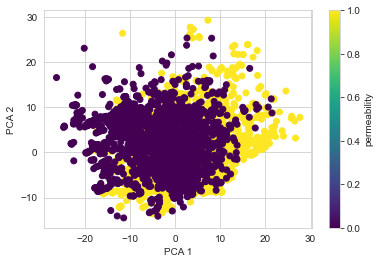

In [3]:
sns.set_style("whitegrid")
# sns.set_palette("Paired")
pca = PCA(n_components=2)
transformed = pca.fit_transform(data_norm)
plt.scatter(transformed[:, 0], transformed[:, 1], c=permeability, cmap='viridis')
plt.colorbar(label='permeability')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.savefig("pics/Projection_permeability.png", dpi=150)
plt.show();

In [9]:
lmnn = metric_learn.LMNN(k=5, learn_rate=1e-6)
lmnn.fit(X_train, y_train)
X_lmnn = lmnn.transform(X_train)

<AxesSubplot:xlabel='f1', ylabel='f2'>

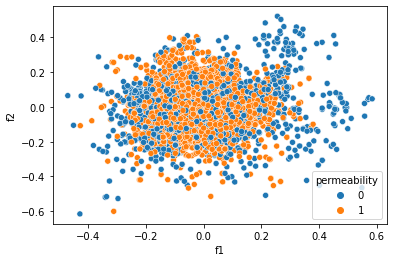

In [5]:
data_train_lmnn = pd.DataFrame(X_lmnn[:, [0, 1]], columns=['f1', 'f2'])
data_train_lmnn['permeability'] = y_train.values

sns.scatterplot(data = data_train_lmnn, x='f1', y='f2', hue='permeability')

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

X_test_lmnn = lmnn.transform(X_test)

model = KNeighborsClassifier(n_neighbors=5).fit(X_lmnn, y_train)
print(model.score(X_test_lmnn, y_test))


# model = GradientBoostingClassifier(n_estimators=50).fit(X_lmnn, y_train)
# model.score(X_test_lmnn, y_test)

0.8809993425378041


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [7]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

model1 = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)

accuracy_score(model1.predict(X_test), y_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


0.8612754766600921

In [8]:
itml = metric_learn.ITML_Supervised()
X_itml_train = itml.fit_transform(X_train, y_train)

/opt/anaconda3/lib/python3.9/site-packages/metric_learn/itml.py:35: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  X = np.vstack({tuple(row) for row in pairs.reshape(-1, pairs.shape[2])})


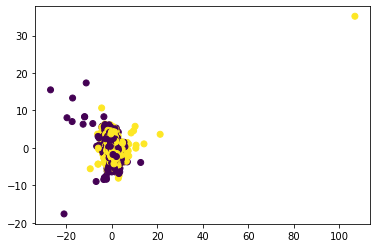

In [9]:
pca = PCA(n_components=5)
transformed = pca.fit_transform(X_itml_train)
plt.scatter(transformed[:, 3], transformed[:, 4], c=y_train)
plt.show();

In [13]:
X_itml_test = lmnn.transform(X_test)

model = KNeighborsClassifier(n_neighbors=89).fit(X_itml_train, y_train)
model.score(X_itml_test, y_test)

0.6719263642340565

In [114]:
mmc = metric_learn.MMC_Supervised()
X_mmc_train = mmc.fit_transform(X_train, y_train)

KeyboardInterrupt: 

In [7]:
import pickle

# filename = 'Model_LMNN.sav'
# pickle.dump(lmnn, open(filename, 'wb'))

## Removing correlated features

In [18]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

data_norm_new = SelectKBest(mutual_info_classif, k=10).fit_transform(data_norm, permeability.values)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(data_norm_new, permeability, test_size=0.2,
                                                    shuffle=True, random_state=42)

lmnn = metric_learn.LMNN(k=5, learn_rate=1e-6)
lmnn.fit(X_train, y_train)
X_train_lmnn = lmnn.transform(X_train)

<AxesSubplot:xlabel='f1', ylabel='Count'>

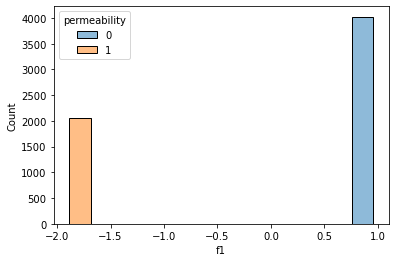

In [24]:
data_train_lmnn = pd.DataFrame(X_train_lmnn[:, [0, 1]], columns=['f1', 'f2'])
data_train_lmnn['permeability'] = y_train.values

sns.histplot(data = data_train_lmnn, x='f1', hue='permeability')

<AxesSubplot:xlabel='f1', ylabel='Count'>

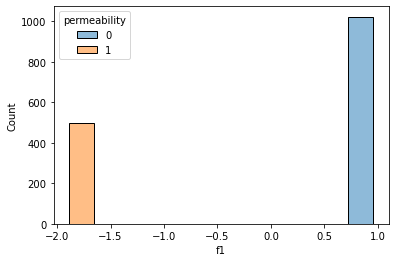

In [25]:
X_test_lmnn = lmnn.transform(X_test)
data_test_lmnn = pd.DataFrame(X_test_lmnn[:, :2], columns=['f1', 'f2'])
data_test_lmnn['permeability'] = y_test.values

sns.histplot(data_test_lmnn, x='f1', hue='permeability')

In [19]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(100, 10)).fit(X_lmnn, y_train)
clf.score(X_test_lmnn, y_test)

0.8717948717948718

## Selecting features of interest

In [17]:
data

,Name,nAcid,ALogP,ALogp2,AMR,naAromAtom,nH,nN,nO,nS,...,Du,P1m,E1m,E2m,E3m,Dm,E1v,E2v,E3v,Dv
0,bbb_1000,0.0,0.9738,0.948286,39.3749,0.0,18.0,0.0,0.0,0.0,...,1.377476,0.658579,0.287331,0.236518,0.029172,0.553022,0.364599,0.327442,0.121527,0.813568
1,bbb_1001,0.0,1.2631,1.595422,88.0868,12.0,16.0,1.0,1.0,0.0,...,1.341867,0.665722,0.763424,0.189462,0.158250,1.111137,0.433962,0.298710,0.257849,0.990521
2,bbb_1002,0.0,0.5360,0.287296,93.0632,12.0,18.0,1.0,2.0,0.0,...,1.332131,0.546680,0.668402,0.202497,0.239803,1.110702,0.308351,0.425550,0.258780,0.992681
3,bbb_1003,0.0,1.9817,3.927135,102.0992,12.0,23.0,2.0,0.0,0.0,...,1.340465,0.523464,0.716766,0.266065,0.174207,1.157038,0.350848,0.362403,0.287105,1.000356
4,bbb_1004,0.0,1.8269,3.337564,92.4810,12.0,21.0,1.0,0.0,0.0,...,1.281980,0.583496,0.285475,0.271028,0.169801,0.726305,0.312462,0.315935,0.260503,0.888900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2550,bbb_98,0.0,1.0981,1.205824,144.7574,0.0,38.0,4.0,2.0,0.0,...,1.290361,0.899547,0.466107,0.193459,0.101559,0.761125,0.480189,0.267812,0.181990,0.929992
2551,bbb_99,0.0,-1.1188,1.251713,53.3859,0.0,10.0,3.0,3.0,1.0,...,1.330354,0.765978,0.374053,0.524683,0.074259,0.972996,0.390675,0.399483,0.145294,0.935452
2552,H1_Bepotastine,1.0,-0.1589,0.025249,106.7680,12.0,25.0,2.0,3.0,0.0,...,1.399667,0.782426,0.802953,0.369577,0.176346,1.348876,0.593094,0.348823,0.265781,1.207698
2553,H1_Quifenadine,0.0,0.5302,0.281112,92.8024,12.0,23.0,1.0,1.0,0.0,...,1.484346,0.529337,0.400308,0.301721,0.183411,0.885440,0.445179,0.341665,0.269765,1.056610



## Building pictures

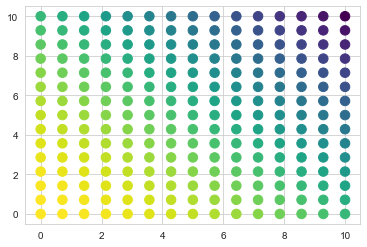

In [59]:
def linear_func(k, b, x):
    return k*x+b

def get_x_proj(k, b, ax, ay, x, y):
    return (x*ax+(y-b)*ay)/(ax+k*ay)



sns.set_style('whitegrid')

x = np.linspace(0, 10, 15)
y = np.linspace(0, 10, 15)

xx, yy = np.meshgrid(x, y)

k = 45
b = 10
ax = -10
ay = -10

proj_x = get_x_proj(k, b, ax, ay, xx, yy)
proj_y = linear_func(k, b, proj_x)

c = np.sqrt((10-proj_x)**2+(proj_y)**2)

plt.scatter(xx, yy, c=c, cmap='viridis_r', s=90)
plt.show();

In [94]:
from sklearn.neighbors import NearestNeighbors
from metric_learn import LSML_Supervised

def sandwich_data():
    # number of distinct classes
    num_classes = 6
    # number of points per class
    num_points = 9
    # distance between layers, the points of each class are in a layer
    dist = 0.7

    data = np.zeros((num_classes, num_points, 2), dtype=float)
    labels = np.zeros((num_classes, num_points), dtype=int)

    x_centers = np.arange(num_points, dtype=float) - num_points / 2
    y_centers = dist * (np.arange(num_classes, dtype=float) - num_classes / 2)
    for i, yc in enumerate(y_centers):
        for k, xc in enumerate(x_centers):
            data[i, k, 0] = np.random.normal(xc, 0.1)
            data[i, k, 1] = np.random.normal(yc, 0.1)
        labels[i, :] = i
    return data.reshape((-1, 2)), labels.ravel()


def plot_sandwich_data(x, y, axis=plt, colors='rbgmky'):
      for idx, val in enumerate(np.unique(y)):
        xi = x[y == val]
        axis.scatter(*xi.T, s=50, facecolors='none', edgecolors=colors[idx])


def plot_neighborhood_graph(x, nn, y, axis=plt, colors='rbgmky'):
      for i, a in enumerate(x):
        b = x[nn[i, 1]]
        axis.plot((a[0], b[0]), (a[1], b[1]), colors[y[i]])
        
def nearest_neighbors(X, k=5):
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(X)
    return knn.kneighbors(X, return_distance=False)

        
# data = sandwich_data()

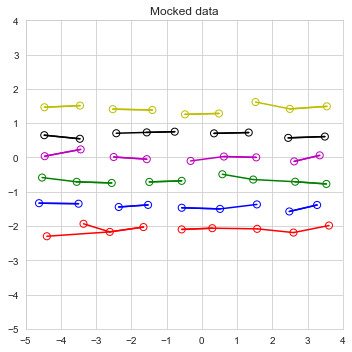

In [109]:
plt.figure(figsize=(5, 5))
# nn = nearest_neighbors(data[0], k=5)
mls = LSML_Supervised(num_constraints=200)
mls.fit(data[0], data[1])
tx = mls.transform(data[0])
ml_knn = nearest_neighbors(tx, k=5)

plot_sandwich_data(data[0], data[1])
plt.title('Mocked data')
plot_neighborhood_graph(data[0], ml_knn, data[1])
plt.xlim(-5, 4)
plt.ylim(-5, 4)
plt.tight_layout()
plt.savefig('pics/Mocked_data_5.png', dpi=150)